<a href="https://colab.research.google.com/github/Leilusen/GBM_model_tuning/blob/master/Fraud_detection_tree_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud detection in card transactions data.

### Setup
Loading files and importing the necessary libraries.

In [0]:
from google.colab import files


In [0]:
uploaded = files.upload()

Saving sample_submission.csv.zip to sample_submission.csv.zip
Saving test_identity.csv.zip to test_identity.csv.zip
Saving test_transaction.csv.zip to test_transaction.csv.zip
Saving train_identity.csv.zip to train_identity.csv.zip
Saving train_transaction.csv.zip to train_transaction.csv.zip


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, TruncatedSVD, PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,4
import gc
#import lightgbm as lgb
from sklearn.metrics import r2_score
import lightgbm as lgb
%matplotlib inline

In [0]:
train_identity = pd.read_csv('train_identity.csv.zip',compression='zip')
train_transaction = pd.read_csv('train_transaction.csv.zip',compression='zip')
test_identity = pd.read_csv('test_identity.csv.zip',compression='zip')
test_transaction = pd.read_csv('test_transaction.csv.zip',compression='zip')
sample_submission = pd.read_csv('sample_submission.csv.zip',compression='zip')


### Data preprocessing

In [0]:
#Reducing memory usage of the dataframes by changing respective datatypes.

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
train = pd.merge(train_transaction, train_identity, how='left', on=['TransactionID'])
del train_transaction, train_identity

test = pd.merge(test_transaction, test_identity, how='left', on=['TransactionID'])
del test_transaction, test_identity

train = train.fillna(-999)
test = test.fillna(-999)

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
train_len = len(train)
test_len = len(test)
train_test = pd.concat([train, test], axis = 0, ignore_index=True)
del train, test

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 650.48 MB
Decreased by 66.8%
Memory usage of dataframe is 1677.73 MB
Memory usage after optimization is: 565.37 MB
Decreased by 66.3%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [0]:
train_test['day'] = train_test['TransactionDT']//86400%7
train_test['hour'] = train_test['TransactionDT']%86400//3600+1
train_test['min'] = train_test['TransactionDT']%86400//60%60+1
train_test['Amt_int'] = train_test['TransactionAmt'].astype(int)
train_test['Amt_fl'] = train_test['TransactionAmt'] - train_test['TransactionAmt'].astype(int)

In [0]:
def encode_cat_feats_fit(df, columns_to_encode):
    encoders={}
    for c in columns_to_encode:
        encoder=LabelEncoder()
        encoder.fit(df[c].astype(str).values)
        encoders[c] = encoder
    return encoders

def encode_cat_feats_transform(df, encoders):
    out = pd.DataFrame(index=df.index)
    for c in encoders.keys():
        out[c] = encoders[c].transform(df[c].astype(str).values)
    return out

categorial_features_columns = [
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
    'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
    'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
    'DeviceType', 'DeviceInfo', 'ProductCD', 'P_emaildomain', 'R_emaildomain',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'P_emaildomain', 'R_emaildomain'
]

cat_feats_encoders = encode_cat_feats_fit(train_test,categorial_features_columns)
temp = encode_cat_feats_transform(train_test,cat_feats_encoders)
columns_to_drop = list(set(categorial_features_columns) & set(train_test.columns))
train_test=train_test.drop(columns_to_drop,axis=1).merge(temp,how='left',left_index=True,right_index=True)
del temp
gc.collect()

70

In [0]:
train_data, test_data = train_test[:train_len], train_test[train_len:]
target='isFraud'
IDcol='TransactionID'

### Gradient Boosting Classifier.

Fitting initial model with default parameters.


Model Report
Accuracy: 0.97
AUC Score: 0.813294


Text(0, 0.5, 'Feature Importance Score')

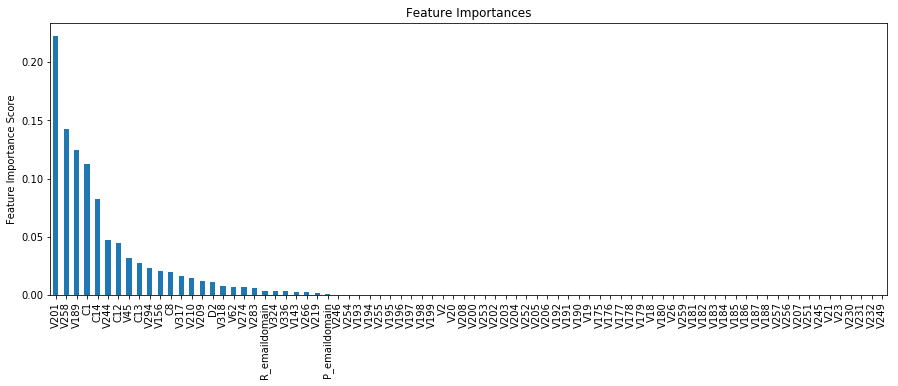

In [0]:
predictors = [x for x in train_test.columns if x not in [target,IDcol]]

X_train, X_test, y_train, y_test = train_test_split(train_data[predictors], train_data[target], test_size=0.2, random_state=10)
model_gbc = GradientBoostingClassifier(n_estimators = 10, random_state=10)
model_gbc.fit(X_train,y_train)

y_pred = model_gbc.predict(X_test)
y_pred_prob = model_gbc.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nModel Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_prob))

feat_imp = pd.Series(model_gbc.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Gradual parameter tuning and assessing AUC score at each stage.

In [0]:
#Choose all predictors except target & IDcols
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch1.fit(train_data[predictors],train_data[target])


In [0]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 60}, 0.8472008127371516)

In [0]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch2.fit(train_data[predictors],train_data[target])

In [0]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 9, 'min_samples_split': 800}, 0.8751905822888435)

In [0]:
param_test3 = {'min_samples_leaf':range(30,81,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=60,max_depth=9, min_samples_split=800, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch3.fit(train_data[predictors],train_data[target])
gsearch3.best_params_, gsearch3.best_score_

In [0]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 40}, 0.875091052709881)

In [0]:
param_test4 = {'max_features':range(14,27,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=60,max_depth=9, min_samples_split=800, min_samples_leaf=40, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch4.fit(train_data[predictors],train_data[target])
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 20}, 0.875091052709881)

In [0]:
param_test5 = {'subsample':[0.5,0.55,0.6,0.65]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, n_estimators=60,max_depth=9,min_samples_split=800, min_samples_leaf=40, random_state=10,max_features=20),
param_grid = param_test5, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch5.fit(train_data[predictors],train_data[target])
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.6}, 0.8820200395445594)

Trying learning rate of one tenth of the one we used for the tuning. Number of trees is increased respectively by a factor of 10.


Model Report
Accuracy: 0.9771
AUC Score: 0.910141


Text(0, 0.5, 'Feature Importance Score')

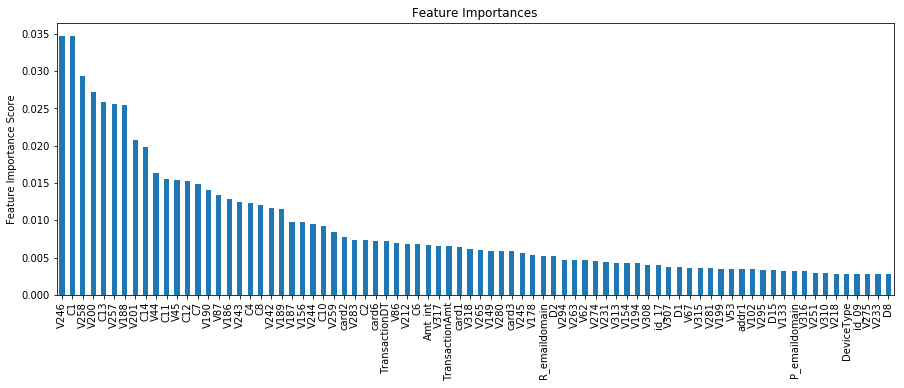

In [0]:
predictors = [x for x in train_test.columns if x not in [target,IDcol]]

X_train, X_test, y_train, y_test = train_test_split(train_data[predictors], train_data[target], test_size=0.2, random_state=10)
model_gbc = GradientBoostingClassifier(
    learning_rate=0.015,
    n_estimators=600,
    max_depth=9,
    min_samples_split=800,
    min_samples_leaf=40,
    subsample=0.6,
    random_state=10,
    max_features=20)
model_gbc.fit(X_train,y_train)

y_pred = model_gbc.predict(X_test)
y_pred_prob = model_gbc.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nModel Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_prob))

feat_imp = pd.Series(model_gbc.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Applying SMOTE to the baseline model.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)



SMOTE Initial Model Report
Accuracy: 0.9192
AUC Score: 0.846736


Text(0, 0.5, 'Feature Importance Score')

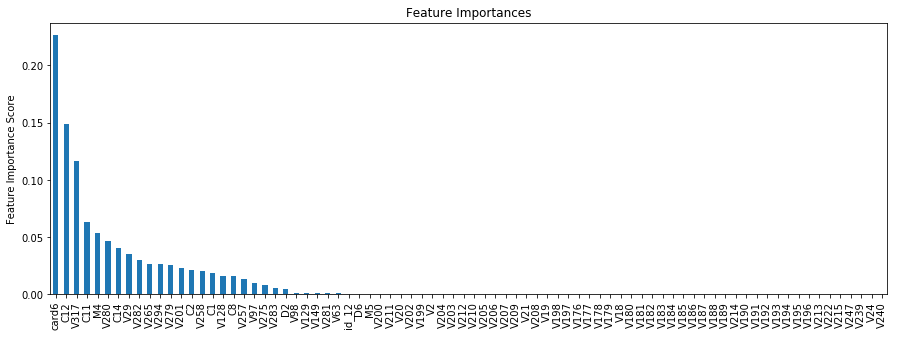

In [0]:
predictors = [x for x in train_test.columns if x not in [target,IDcol]]

from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(train_data[predictors], train_data[target], test_size=0.2, random_state=10)
sm = SMOTE(random_state=10,ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

model_gbc = GradientBoostingClassifier(n_estimators = 10, random_state=10)
model_gbc.fit(X_train,y_train)

y_pred_smote_init = model_gbc.predict(X_test)
y_pred_prob_smote_init = model_gbc.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nSMOTE Initial Model Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_smote_init))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_prob_smote_init))

feat_imp = pd.Series(model_gbc.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Applying SMOTE to the tuned model.


SMOTE Tuned Model Report
Accuracy: 0.9777
AUC Score: 0.913617


Text(0, 0.5, 'Feature Importance Score')

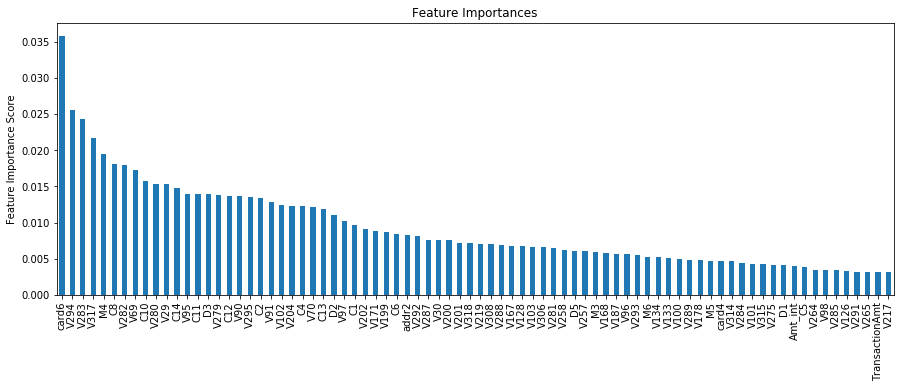

In [0]:
predictors = [x for x in train_test.columns if x not in [target,IDcol]]

from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(train_data[predictors], train_data[target], test_size=0.2, random_state=10)
sm = SMOTE(random_state=10,ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

model_gbc = GradientBoostingClassifier(
    learning_rate=0.015,
    n_estimators=600,
    max_depth=9,
    min_samples_split=800,
    min_samples_leaf=40,
    subsample=0.6,
    random_state=10,
    max_features=20)
model_gbc.fit(X_train,y_train)

y_pred_smote_tuned = model_gbc.predict(X_test)
y_pred_prob_smote_tuned = model_gbc.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nSMOTE Tuned Model Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_smote_tuned))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_prob_smote_tuned))

feat_imp = pd.Series(model_gbc.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')